In [1]:
import numpy as np
import pandas as pd
import scipy.io as sp
from scipy.special import softmax
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.preprocessing import StandardScaler

In [2]:
def to_classlabel(z):
    return z.argmax(axis = 1)

In [3]:
def one_hot_encode(y):
    n_class = np.unique(y).shape[0]
    y_encode = np.zeros((y.shape[0], n_class))
    for idx, val in enumerate(y):
        y_encode[idx, val] = 1.0
    return y_encode

In [4]:
# Define Accuracy
def accuracy(y_true, y_pred):
    acc = np.sum(y_true == y_pred) / len(y_true)
    return acc

In [ ]:
def loss(A, Y, W, mu):
    """
    Y: onehot encoded
    """
    #Z seria la hipotesis A matriz de disneio y W theha, mu - lamnda de regularizacion 
    # la funcion de perdida categorica 
    Z = A @ W
    N = A.shape[0]
    loss = 1/N * (-np.trace(A @ W @ Y.T) + np.sum(np.log(np.sum(np.exp(Z), axis=1)))) #perdida sin regularizacion 
    reg = mu*np.linalg.norm(W,'fro')**2 #usa la formula 2 (modelos de regresion pg 28)
    lossreg = loss + reg
    return lossreg

In [ ]:
def gradient(A, Y, W, mu):
    """
    Y: onehot encoded 
    """
    Z = A @ W
    P = softmax(Z, axis=1) #probabilidad 
    N = A.shape[0]
    gd = -1/N * (A.T @ (Y - P)) + 2 * mu * W #mu - lambda 
    return gd

In [ ]:
#entrenamiento 
def gradient_descent(A, Y, max_iter=1000, eta=0.1, mu=0.01):
    """
    Very basic gradient descent algorithm with fixed eta and mu
    """
    Y_onehot = one_hot_encode(Y)
    W = np.zeros((A.shape[1], Y_onehot.shape[1])) #thetah numero de parametos por el numero de etiquetas 
    step = 0
    step_lst = [] 
    loss_lst = []
    W_lst = []
 
    while step < max_iter:
        step += 1
        W -= eta * gradient(A, Y_onehot, W, mu)
        #historiales se pasos, pesos 
        step_lst.append(step)
        W_lst.append(W)
        loss_lst.append(loss(A, Y_onehot, W, mu))

    df = pd.DataFrame({
        'step': step_lst, 
        'loss': loss_lst
    })
    return df, W #W parametros 

In [ ]:
# Multiclass logistic regression
#modificar para lotes, minilotes, online 
class Multiclass:
    def fit(self, A, Y):
        self.loss_steps, self.W = gradient_descent(A, Y)

    def loss_plot(self):
        return self.loss_steps.plot(
            x='step', 
            y='loss',
            xlabel='Epochs',
            ylabel='MCCE loss'
        )

    def predict(self, A):
        Z = A @ self.W #hipotesis 
        P = softmax(Z, axis=1) #probalidad. 
        return to_classlabel(P)

In [9]:
# load dataset

data = np.loadtxt('admisiones_dataset.txt',delimiter = ',')
inputs = data[:,0:2]
idx = data[:,2]-1
targets = np.array(idx, dtype=int)  # codificacion categorica

In [10]:
# Split the data
X_train,X_test,Y_train,Y_test = train_test_split(inputs,targets,test_size=0.40,random_state=1234)

In [ ]:
# Standardize the data
scaler  = StandardScaler()
X_train = scaler.fit_transform(X_train) #nromaizlar los datos 
X_test  = scaler.fit_transform(X_test)

In [12]:
# Design Matrix
A_train = np.c_[np.ones(len(X_train)), X_train]
A_test  = np.c_[np.ones(len(X_test)), X_test]

In [13]:
# fit model
model = Multiclass()
model.fit(A_train, Y_train)

<Axes: xlabel='Epochs', ylabel='MCCE loss'>

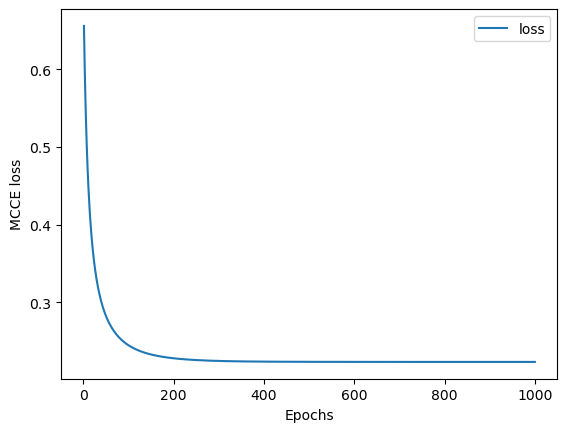

In [14]:
# plot loss
model.loss_plot()

In [15]:
# predict 
train_pred = model.predict(A_train)

In [16]:
# Calculate accuracy
train_acc = accuracy(Y_train, train_pred)
print(f'Accuracy on training set: {train_acc}')

Accuracy on training set: 0.95


In [17]:
# Calculate metrics
cm_train = confusion_matrix(Y_train, train_pred)
train_report = classification_report(Y_train, train_pred)

print("Performance on training set:\n")
print(f'Confusion Matrix:\n {cm_train}\n')
print(f'Classification Report:\n {train_report}')

Performance on training set:

Confusion Matrix:
 [[25  1]
 [ 2 32]]

Classification Report:
               precision    recall  f1-score   support

           0       0.93      0.96      0.94        26
           1       0.97      0.94      0.96        34

    accuracy                           0.95        60
   macro avg       0.95      0.95      0.95        60
weighted avg       0.95      0.95      0.95        60



In [ ]:
#datos que no se entrenaron.


# Create predictions on test set
test_pred = model.predict(A_test)

In [19]:
# Calculate accuracy
test_acc = accuracy(Y_test, test_pred)
print(f'Accuracy on test set: {test_acc}')

Accuracy on test set: 0.825


In [20]:
# Calculate metrics
cm_test = confusion_matrix(Y_test, test_pred)
test_report = classification_report(Y_test, test_pred)

print("Performance on test set:\n")
print(f'Confusion Matrix:\n {cm_test}\n')
print(f'Classification Report:\n {test_report}')

Performance on test set:

Confusion Matrix:
 [[10  4]
 [ 3 23]]

Classification Report:
               precision    recall  f1-score   support

           0       0.77      0.71      0.74        14
           1       0.85      0.88      0.87        26

    accuracy                           0.82        40
   macro avg       0.81      0.80      0.80        40
weighted avg       0.82      0.82      0.82        40



In [21]:
THETA = model.W
print(THETA)

[[-0.46543597  0.46543597]
 [-1.2769459   1.2769459 ]
 [-1.11610903  1.11610903]]
